In [1]:
from tqdm import tqdm as tqdm

In [3]:
!pip install cfbd --quiet

In [4]:
!pip install flatdict --quiet
import flatdict

In [6]:
import matplotlib as plt
import pandas as pd
from __future__ import print_function
import time
import cfbd
from cfbd.rest import ApiException
from pprint import pprint

# Configure API key authorization: ApiKeyAuth
configuration = cfbd.Configuration()
configuration.api_key['Authorization'] = '6xP5nG7U8YjQCcW6OAIX7C4U5V7YezgEnPhOn7/W0MjMzXCI1mcWuKFKgegJmX+G'
configuration.api_key_prefix['Authorization'] = 'Bearer'

In [10]:
stats_api_instance = cfbd.StatsApi(cfbd.ApiClient(configuration))

In [ ]:
xclude_garbage_time= True

In [19]:
def generate_advanced_team_game_stats_df(team, year=2024, season_type='regular'):
    
    #grab the advancated teams data
    games = stats_api_instance.get_advanced_team_game_stats(team=team, year=year, season_type=season_type, exclude_garbage_time= True)
    
    #initialize empty dictionary which we will pass in to our DataFrame.
    games_df_data = dict()
    
    for game in games:
        #convert the game object to dictionary since it's something else at the moment even though it looks like one. Won't be able to access dictionary methods.
        game_dict = game.to_dict()
        #flatten the dictionary, use the delimiter .
        flattened_game_dict = flatdict.FlatDict(game_dict, delimiter='.')
        
        for k, v in flattened_game_dict.items():
            #if this is the first dict we've gone through, initialize our empty DataFrame with the correct kets
            if k not in games_df_data:
                games_df_data[k] = []
            #otherwise append. We are using a list here but we could use Series or list objects to contruct DataFrames
            games_df_data[k].append(v)
            
    return pd.DataFrame(games_df_data)

In [20]:
kirby_df = generate_advanced_team_game_stats_df('Georgia')
tide_df = generate_advanced_team_game_stats_df('Alabama')

tide_df.head()

,game_id,season,week,team,opponent,offense.plays,offense.drives,offense.ppa,offense.total_ppa,offense.success_rate,...,defense.passing_downs.success_rate,defense.passing_downs.explosiveness,defense.rushing_plays.ppa,defense.rushing_plays.total_ppa,defense.rushing_plays.success_rate,defense.rushing_plays.explosiveness,defense.passing_plays.ppa,defense.passing_plays.total_ppa,defense.passing_plays.success_rate,defense.passing_plays.explosiveness
0,401628319,None,1,Alabama,Western Kentucky,65,14,0.671310,43.635162,0.492308,...,0.138889,1.774230,-0.415749,-10.809485,0.115385,0.817390,-0.161731,-6.630966,0.170732,1.626537
1,401628335,None,2,Alabama,South Florida,67,16,0.262745,17.603908,0.402985,...,0.153846,2.022206,0.145847,6.125556,0.333333,1.205802,-0.228995,-9.159808,0.225000,1.054071
2,401628350,None,3,Alabama,Wisconsin,56,12,0.412156,23.080755,0.482143,...,0.300000,1.360695,-0.052452,-2.150540,0.463415,0.613505,0.173245,5.370600,0.322581,1.559695
3,401628374,None,5,Alabama,Georgia,70,14,0.294012,20.580838,0.471429,...,0.296296,1.396293,0.357630,8.940751,0.480000,1.152694,0.258741,13.195801,0.411765,1.863592
4,401628384,None,6,Alabama,Vanderbilt,45,10,0.464147,20.886612,0.555556,...,0.416667,2.228449,-0.130419,-6.912208,0.320755,0.888542,1.195833,25.112499,0.666667,2.091545


In [21]:
tide_df['net_success'] = tide_df['offense.success_rate'] - tide_df['defense.success_rate']

In [28]:
result = ['win','win','win','win','loss','win','loss','win','win','win','loss','win']

In [29]:
tide_df['Results'] = result

In [30]:
tide_df['net_explosiveness'] = tide_df['offense.explosiveness']- tide_df['defense.explosiveness']

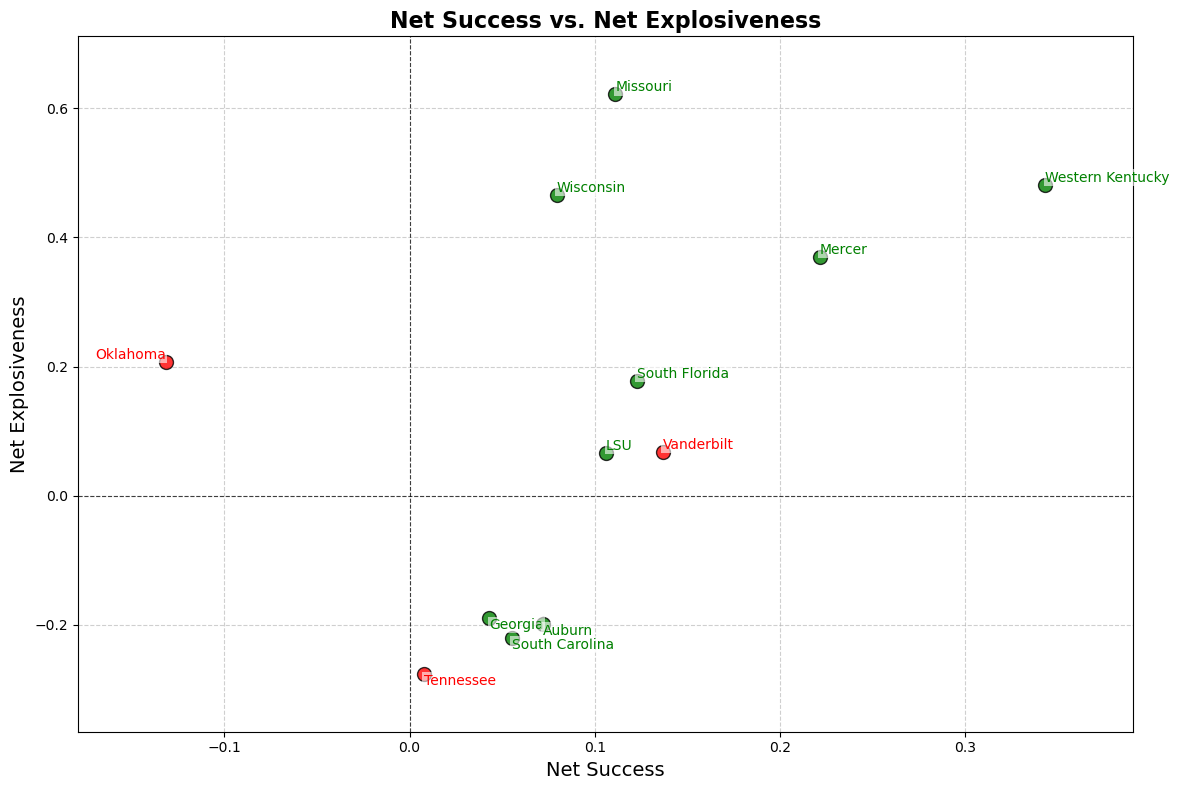

In [37]:
df = tide_df

# Initialize the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot data points and add text labels
for _, row in df.iterrows():
    color = 'green' if row['Results'] == 'win' else 'red'
    ax.scatter(row['net_success'], row['net_explosiveness'], color=color, s=100, alpha=0.8, edgecolor='black', zorder=2)
    
    # Determine text alignment based on quadrant to prevent overlap
    if row['net_success'] >= 0 and row['net_explosiveness'] >= 0:
        ha = 'left'
        va = 'bottom'
    elif row['net_success'] < 0 and row['net_explosiveness'] >= 0:
        ha = 'right'
        va = 'bottom'
    elif row['net_success'] < 0 and row['net_explosiveness'] < 0:
        ha = 'right'
        va = 'top'
    else:
        ha = 'left'
        va = 'top'
    
    # Add text without significant offset
    ax.text(row['net_success'], row['net_explosiveness'], row['opponent'], color=color, fontsize=10,
            ha=ha, va=va, 
            bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=1))

# Dynamic axis limits with proportional padding
x_range = df['net_success'].max() - df['net_success'].min()
y_range = df['net_explosiveness'].max() - df['net_explosiveness'].min()
x_padding = x_range * 0.1
y_padding = y_range * 0.1

ax.set_xlim(df['net_success'].min() - x_padding, df['net_success'].max() + x_padding)
ax.set_ylim(df['net_explosiveness'].min() - y_padding, df['net_explosiveness'].max() + y_padding)

# Add grid, labels, and title
ax.grid(True, linestyle='--', alpha=0.6, zorder=1)
ax.set_xlabel('Net Success', fontsize=14)
ax.set_ylabel('Net Explosiveness', fontsize=14)
ax.set_title('Net Success vs. Net Explosiveness', fontsize=16, weight='bold')

# Add zero lines for better orientation
ax.axhline(0, color='black', linewidth=0.8, linestyle='--', alpha=0.7)
ax.axvline(0, color='black', linewidth=0.8, linestyle='--', alpha=0.7)

# Improve layout
plt.tight_layout()

# Display the plot
plt.show()


In [31]:
stats_api_instance = cfbd.StatsApi(cfbd.ApiClient(configuration))
#year = 2024 # int | Year filter (required if no team specified) (optional)
#week = 9 # int | Week filter (optional)
#team = 'arizona state' # str | Team filter (required if no year specified) (optional)
#opponent = 'opponent_example' # str | Opponent filter (optional)
#exclude_garbage_time = True # bool | Filter to remove garbage time plays from calculations (optional)
#season_type = 'season_type_example' # str | Season type filter (regular, postseason, or both) (optional)

try:
    # Advanced team metrics by game
    api_response = stats_api_instance.get_advanced_team_game_stats(year=2024, week=12, team = 'Florida',exclude_garbage_time= True, season_type='regular')
    pprint(api_response)
except ApiException as e:
    print("Exception when calling StatsApi->get_advanced_team_game_stats: %s\n" % e)

[{'defense': {'drives': 10,
             'explosiveness': 1.4607183428635022,
             'line_yards': 2.9289473684210527,
             'line_yards_total': 111.0,
             'open_field_yards': 1.0526315789473684,
             'open_field_yards_total': 40,
             'passing_downs': {'explosiveness': 2.129043301681881,
                               'ppa': 0.4005746848824959,
                               'success_rate': 0.3333333333333333},
             'passing_plays': {'explosiveness': 1.9811329362019001,
                               'ppa': 0.14482482378531666,
                               'success_rate': 0.3148148148148148,
                               'total_ppa': 7.8205404844071},
             'plays': 92,
             'power_success': 0.6666666666666666,
             'ppa': 0.11296213590217538,
             'rushing_plays': {'explosiveness': 0.8709151370799846,
                               'ppa': 0.06768357943665884,
                               'success_rate':

In [43]:
def generate_advanced_team_game_stats_df(team, year=2024, season_type='regular'):
    
    #grab the advancated teams data
    games = stats_api_instance.get_advanced_team_game_stats(team=team, year=year, season_type=season_type)
    
    #initialize empty dictionary which we will pass in to our DataFrame.
    games_df_data = dict()
    
    for game in games:
        #convert the game object to dictionary since it's something else at the moment even though it looks like one. Won't be able to access dictionary methods.
        game_dict = game.to_dict()
        #flatten the dictionary, use the delimiter .
        flattened_game_dict = flatdict.FlatDict(game_dict, delimiter='.')
        
        for k, v in flattened_game_dict.items():
            #if this is the first dict we've gone through, initialize our empty DataFrame with the correct kets
            if k not in games_df_data:
                games_df_data[k] = []
            #otherwise append. We are using a list here but we could use Series or list objects to contruct DataFrames
            games_df_data[k].append(v)
            
    return pd.DataFrame(games_df_data)

In [44]:
lsu_df = generate_advanced_team_game_stats_df('LSU')
uf_df = generate_advanced_team_game_stats_df('Florida')

uf_df.head()

,game_id,season,week,team,opponent,offense.plays,offense.drives,offense.ppa,offense.total_ppa,offense.success_rate,...,defense.passing_downs.success_rate,defense.passing_downs.explosiveness,defense.rushing_plays.ppa,defense.rushing_plays.total_ppa,defense.rushing_plays.success_rate,defense.rushing_plays.explosiveness,defense.passing_plays.ppa,defense.passing_plays.total_ppa,defense.passing_plays.success_rate,defense.passing_plays.explosiveness
0,401628322,None,1,Florida,Miami,54,12,-0.054250,-2.929501,0.407407,...,0.388889,2.543883,0.212413,6.797218,0.437500,0.872709,0.599246,22.172084,0.513514,1.593786
1,401628338,None,2,Florida,Samford,62,12,0.490310,30.399194,0.532258,...,0.296296,1.608368,-0.067561,-2.297070,0.352941,0.821417,-0.135727,-4.343263,0.343750,1.010856
2,401628353,None,3,Florida,Texas A&M,54,10,0.090663,4.895794,0.462963,...,0.440000,2.575986,0.184752,9.976616,0.462963,0.842410,0.911574,15.496754,0.352941,3.429265
3,401628367,None,4,Florida,Mississippi State,64,11,0.449369,28.759593,0.625000,...,0.384615,1.916692,0.347483,18.416621,0.509434,1.120786,0.149883,5.395792,0.361111,1.669161
4,401628380,None,6,Florida,UCF,63,10,0.160045,10.082848,0.444444,...,0.312500,1.688882,0.128291,4.490197,0.571429,0.571369,-0.027472,-0.741757,0.370370,1.251899


In [45]:
lsu_df.head()

,game_id,season,week,team,opponent,offense.plays,offense.drives,offense.ppa,offense.total_ppa,offense.success_rate,...,defense.passing_downs.success_rate,defense.passing_downs.explosiveness,defense.rushing_plays.ppa,defense.rushing_plays.total_ppa,defense.rushing_plays.success_rate,defense.rushing_plays.explosiveness,defense.passing_plays.ppa,defense.passing_plays.total_ppa,defense.passing_plays.success_rate,defense.passing_plays.explosiveness
0,401628334,None,1,LSU,USC,64,10,0.240010,15.360659,0.421875,...,0.357143,2.301280,-0.092530,-1.943138,0.428571,0.700927,0.558108,20.650006,0.621622,1.260713
1,401628341,None,2,LSU,Nicholls,59,11,0.413595,24.402088,0.542373,...,0.300000,1.715369,0.064198,2.439530,0.289474,1.361116,0.388048,8.149004,0.476190,1.702403
2,401628359,None,3,LSU,South Carolina,72,14,0.171641,12.358155,0.444444,...,0.260870,2.152840,0.389526,14.801985,0.394737,1.626733,0.027322,0.628409,0.304348,1.917628
3,401628365,None,4,LSU,UCLA,72,10,0.265188,19.093552,0.541667,...,0.375000,2.256068,-0.371758,-6.319889,0.294118,1.027997,0.279272,11.450136,0.365854,1.824421
4,401628376,None,5,LSU,South Alabama,69,11,0.513642,35.441287,0.536232,...,0.266667,1.709593,0.007276,0.218265,0.466667,0.571600,0.269194,8.614200,0.500000,1.412916
